In [0]:
import keras
import numpy as np
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab style plot
import seaborn as sns # affichage, on peut utiliser d'autres librairies
import statsmodels.api as sm # modèle stat contenant le modèle ARIMA
from pylab import *
from scipy import stats
from scipy.stats import normaltest
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

Using TensorFlow backend.


In [0]:
ls

ref_phase2_train_x.csv  ref_test_x.csv   ref_valid_x.csv
ref_phase2_train_y.csv  ref_train_x.csv  sample_data/
ref_phase2_valid_x.csv  ref_train_y.csv


## Data preparation and preprocessing

In [0]:
sp_train = pd.read_csv("ref_train_x.csv").drop( columns = ["raw_id"])
col_names = sp_train.columns
sp_y_train = pd.read_csv("ref_train_y.csv", names = ["Target"])
sp_test = pd.read_csv("ref_test_x.csv").drop( columns = ["raw_id"])
sp_val= pd.read_csv("ref_valid_x.csv").drop( columns = ["raw_id"])
sp_val.head()

,sector,earnings_implied_obs,delta_vol_1w,delta_vol_1y,return_1w,return_1m,return_1y,implied_vol_3m,realised_vol_1w,realised_vol_1m,realised_vol_1y,ratio_put_call,publication_date_funda,exchange,net_income,shareholders_equity,net_debt,ebitda,ebit,sales,cash_flow,payout_ratio
0,4700,2.4461,0.1735,2.1648,-1.0713,4.8328,11.6924,22.7856,1.180800,1.375023,1.191461,0.295143,332.0,US,0.053045,0.607667,0.629030,0.188284,0.113513,0.547924,0.164567,67.083333
1,4700,4.7421,-0.0019,-0.8875,-0.0854,-2.9170,26.9056,17.7426,0.707194,0.800064,1.163401,0.309301,161.0,US,0.049732,0.548312,0.574994,0.169877,0.099385,0.481372,0.149906,63.899614
2,4700,2.6895,0.2251,-3.8361,-2.1077,-1.5320,15.6661,15.8499,0.623590,0.615243,1.047727,0.406421,65.0,US,0.049070,0.533757,0.588012,0.173886,0.103776,0.456583,0.149013,63.992537
3,1200,3.6157,-2.9473,2.2332,7.0837,0.5461,8.0946,20.5666,1.979139,1.972296,1.080879,0.295469,244.0,US,0.042230,0.256167,0.091474,0.076270,0.066578,0.293579,0.052240,11.428571
4,1200,3.7540,-0.3427,2.8985,-2.3332,-16.0613,-6.7157,27.3656,1.544946,1.400208,1.295192,0.750094,346.0,US,0.053010,0.293828,0.121212,0.094071,0.081502,0.364791,0.069170,13.924051


In [0]:
sp_y_train.shape

(15249, 1)

In [0]:
df_train = sp_train.copy()
df_train["Target"]= sp_y_train;df_train.head(3)

,sector,earnings_implied_obs,delta_vol_1w,delta_vol_1y,return_1w,return_1m,return_1y,implied_vol_3m,realised_vol_1w,realised_vol_1m,realised_vol_1y,ratio_put_call,publication_date_funda,exchange,net_income,shareholders_equity,net_debt,ebitda,ebit,sales,cash_flow,payout_ratio,Target
0,4700,3.7452,-0.3692,-0.0972,2.2375,1.1495,22.1040,17.1714,0.787627,0.884178,1.401695,0.516182,364.0,US,0.018193,1.011748,0.924447,0.306404,0.196460,1.000361,0.245411,265.517241,0
1,4700,3.2026,-0.6008,0.6127,3.3098,1.3508,17.5971,15.9524,0.939068,0.833054,1.370815,0.540048,66.0,US,0.065461,0.998823,0.836746,0.280513,0.173050,0.950767,0.225520,72.325581,0
2,4700,4.4641,1.6247,-5.4056,-0.6884,-2.3511,6.2714,16.4591,0.959970,0.714396,0.907072,0.558759,255.0,US,0.065711,1.002628,0.839933,0.281582,0.173709,0.954389,0.226379,72.325581,0


In [0]:
df_train.describe()

,sector,earnings_implied_obs,delta_vol_1w,delta_vol_1y,return_1w,return_1m,return_1y,implied_vol_3m,realised_vol_1w,realised_vol_1m,realised_vol_1y,ratio_put_call,publication_date_funda,net_income,shareholders_equity,net_debt,ebitda,ebit,sales,cash_flow,payout_ratio,Target
count,15249.000000,15229.000000,15239.000000,15021.000000,15248.000000,15248.000000,15248.000000,15244.000000,15246.000000,15246.000000,15247.000000,15154.000000,15234.000000,15232.000000,15228.000000,15229.000000,13380.000000,13384.000000,15231.000000,15223.000000,15155.000000,15249.000000
mean,3038.146764,4.123989,0.305965,0.714170,0.148589,1.483637,13.256354,26.903479,1.452244,1.504748,1.674337,0.484258,206.854011,0.034064,0.498687,0.644835,0.136042,0.085556,0.993146,0.118811,71.237165,0.267690
std,1314.944072,2.524939,3.679804,9.630336,3.754969,7.425006,25.285679,10.264673,0.827564,0.829296,0.675579,0.155217,106.594922,0.478796,0.535053,3.891682,0.148875,0.111803,1.454851,0.326089,574.784253,0.442769
min,1100.000000,0.034300,-102.059100,-297.204800,-102.875600,-50.447900,-186.668800,5.070000,0.141037,0.128684,0.495623,0.000070,4.000000,-53.872876,-16.984842,-10.718349,-5.507148,-6.746918,-0.186518,-1.730255,0.000000,0.000000
25%,2100.000000,2.765700,-0.677250,-2.615200,-1.695175,-2.658975,-0.380800,20.942550,0.946495,1.044182,1.235449,0.395233,134.000000,0.028509,0.203876,0.019968,0.070662,0.049929,0.304341,0.055226,17.790398,0.000000
50%,3200.000000,3.645000,0.129000,0.890800,0.321100,1.751250,14.078700,24.898550,1.287629,1.347276,1.513283,0.488074,189.000000,0.046449,0.360802,0.155451,0.104280,0.073895,0.571448,0.084738,36.512262,0.000000
75%,4700.000000,4.878000,1.087100,4.205800,2.163650,5.813400,28.085200,30.333475,1.750571,1.760508,1.932164,0.576929,321.000000,0.068174,0.646414,0.436791,0.162991,0.106413,1.143283,0.138782,60.169492,1.000000
max,6000.000000,96.156200,297.876900,288.698800,49.581700,103.039800,192.361700,329.046700,26.094069,38.178429,12.798581,0.999917,931.000000,0.888207,19.549657,362.873617,5.016946,4.711881,33.675033,36.050037,40483.870968,1.000000


In [0]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15249 entries, 0 to 15248
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   sector                  15249 non-null  int64  
 1   earnings_implied_obs    15229 non-null  float64
 2   delta_vol_1w            15239 non-null  float64
 3   delta_vol_1y            15021 non-null  float64
 4   return_1w               15248 non-null  float64
 5   return_1m               15248 non-null  float64
 6   return_1y               15248 non-null  float64
 7   implied_vol_3m          15244 non-null  float64
 8   realised_vol_1w         15246 non-null  float64
 9   realised_vol_1m         15246 non-null  float64
 10  realised_vol_1y         15247 non-null  float64
 11  ratio_put_call          15154 non-null  float64
 12  publication_date_funda  15234 non-null  float64
 13  exchange                15249 non-null  object 
 14  net_income              15232 non-null

In [0]:
100*df_train.isna().sum()/len(df_train)

sector                     0.000000
earnings_implied_obs       0.131156
delta_vol_1w               0.065578
delta_vol_1y               1.495180
return_1w                  0.006558
return_1m                  0.006558
return_1y                  0.006558
implied_vol_3m             0.032789
realised_vol_1w            0.019673
realised_vol_1m            0.019673
realised_vol_1y            0.013116
ratio_put_call             0.622992
publication_date_funda     0.098367
exchange                   0.000000
net_income                 0.111483
shareholders_equity        0.137714
net_debt                   0.131156
ebitda                    12.256541
ebit                      12.230310
sales                      0.118041
cash_flow                  0.170503
payout_ratio               0.616434
Target                     0.000000
dtype: float64

**Remarque** As we can see there are a lot of missing values. Let's first fill these values using K Nearnerst Neighboors imputer.

In [0]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df_train["exchange"] = le.fit_transform(df_train["exchange"])


## Fill missing values

After filling the missing values we will normalise the data using standard scaler.

In [0]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
df_filled = imputer.fit_transform(df_train)

In [0]:
df_filled = preprocessing.StandardScaler().fit_transform(df_filled)

In [0]:
df_processed = pd.DataFrame(df_filled, columns=df_train.columns); 
df_processed["exchange"] = df_train["exchange"] # categorical
df_processed["sector"]= df_train["sector"]  # categorical
df_processed["Target"] = sp_y_train; df_processed.head(3) 

,sector,earnings_implied_obs,delta_vol_1w,delta_vol_1y,return_1w,return_1m,return_1y,implied_vol_3m,realised_vol_1w,realised_vol_1m,realised_vol_1y,ratio_put_call,publication_date_funda,exchange,net_income,shareholders_equity,net_debt,ebitda,ebit,sales,cash_flow,payout_ratio,Target
0,4700,-0.149878,-0.183492,-0.084173,0.556348,-0.045019,0.349952,-0.948229,-0.803235,-0.748458,-0.403664,0.206212,1.474862,1,-0.033193,0.959266,0.071839,1.184700,1.004863,0.004849,0.388602,0.333115,0
1,4700,-0.364892,-0.246451,-0.010001,0.841935,-0.017906,0.171702,-1.067004,-0.620218,-0.810111,-0.449378,0.360291,-1.321992,1,0.065589,0.935095,0.049292,1.005031,0.789141,-0.029252,0.327551,0.000251,0
2,4700,0.134998,0.358546,-0.638807,-0.222910,-0.516510,-0.276235,-1.017633,-0.594958,-0.953209,-1.135869,0.481084,0.451852,1,0.066110,0.942210,0.050111,1.012447,0.795215,-0.026761,0.330187,0.000251,0


In [0]:
df_processed["Target"].isna().sum()

0

In [0]:
df_processed["Target"].value_counts()*100/len(df_processed)

0    73.231032
1    26.768968
Name: Target, dtype: float64

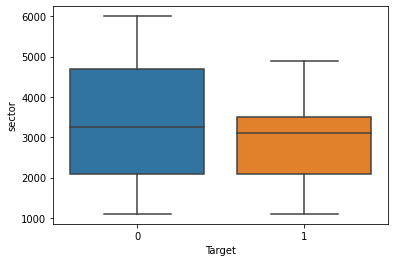

In [0]:
sns.boxplot(x="Target", y="sector", data=df_processed)


The dataset seems to be highly unbalanced. I will try to deal with that using to simple stratagies : class_weights and oversampling.

## Train-test splitting

In [0]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df_processed, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)



In [0]:
test_df["Target"].value_counts()*100/len(test_df)

0    75.213115
1    24.786885
Name: Target, dtype: float64

In [0]:
df = train_df.copy() # Form np arrays of labels and features.
train_labels = np.array(df.pop('Target'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Target'))
test_labels = np.array(test_df.pop('Target'))

input_shape = df.shape[-1]

train_features = np.array(df).reshape(-1, input_shape, 1)
val_features = np.array(val_df).reshape(-1, input_shape, 1)
test_features = np.array(test_df).reshape(-1, input_shape, 1)

In [0]:
np.where (isnan((train_labels)) == True)

(array([], dtype=int64),)

## Utils

In [0]:
from keras.layers import *
import keras
import tensorflow as tf

In [0]:
from keras import Sequential

In [0]:
def build_MLP( input_shape, activation = 'relu', units = [100,100], momentum=0.1, epsilon=1e-05, dropout_rate = 0,
              optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy']):
    
    """
    build a neural network with linear blocks fellowed by non linear activations. Every block consists of
     BatchNormalization, Dropout and a  dense layer. The depth of the network can be custumized in parameter "units"


  	Parameters:
    ----------

  	input_shape : tuple of integers.
        Correspond to the shape of the input samples.
    units: list of integers.
        Define the number of units of every linear block of the network. Thus len(units) define the depth of the network. If "units" is an empty list, the built model correspond to a logistic regression preceded by a BatchNormalization.

	Return:
    ------

	model : Keras Sequential object
			Compiled model with a binary crossentropy loss and accuracy metric.

    Author : Amine  
    """


    model = Sequential()
    model.add(BatchNormalization(axis=1, momentum=momentum, epsilon=epsilon, input_shape = input_shape))
    
    for n_units in units: 
      model.add(Dropout(dropout_rate))
      model.add(Dense(units=n_units,  activation=activation))
      model.add(BatchNormalization(axis=1, momentum=momentum, epsilon=epsilon))

    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1, activation='softmax'))     
    
    model.compile(loss= loss , 
                      optimizer=optimizer, 
                      metrics=metrics)
    
    

    return model

def build_CNN(input_shape, filters= [3], kernels = [4], activation = 'relu', optimizer= 'Adam', metrics = ['accuracy'], output_bias=None, dropout = 0.5, reg = 0):
    
    """
    build a  convolutionnal neural network . Every block consists of BatchNormalization, Dropout and a 
    1 dimensionnal   convolution. The depth of the network can be custumized in parameters  "kernels" 
    and "filters". It correspond to max ( len(filters), len(kernels)).


    Parameters:
    ----------
    input_shape : tuple of integers
        Correspond to the shape of the input samples.
    filters: list of integers
        Define the number of filters  of every 1 dimensionnal convolution. 
    kernels : list of integers
        Define the kernel size of the filters  of every 1 dimensionnal convolution. 
    Return:
    ------

    model : Keras Sequential object
        Compiled model with a binary crossentropy loss and accuracy metric.
    Author : Amine.  

    """
    if output_bias is not None:
      output_bias = keras.initializers.Constant(output_bias)
    model = Sequential()
    model.add(BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05, input_shape = input_shape))
    model.add( Conv1D(filters=3, kernel_size= 4, strides =1, activation = activation))
    for (f, k) in zip(filters, kernels):
        
        model.add(BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05))
        model.add(Dropout(dropout))
        model.add(Conv1D(filters=f, kernel_size= k, strides =1,kernel_regularizer=regularizers.l2(reg), bias_regularizer=regularizers.l2(reg), activation = activation))
        model.add(MaxPooling1D())

    model.add(Flatten())
    model.add(BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05))
    model.add(Dropout(0.1))
    model.add(Dense(units=1, activation='sigmoid', bias_initializer=output_bias, kernel_regularizer=regularizers.l2(reg), bias_regularizer=regularizers.l2(reg))) 



    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=metrics)


    return model 



In [0]:
def plot_metrics(history):
  metrics =  ['loss', 'auc',"accuracy"]
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [0]:
from sklearn.metrics import confusion_matrix

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])
  print('Total : ', np.sum(cm[1]))

## A convolutionnal neural network

In [0]:
METRICS = [
     # keras.metrics.TruePositives(name='tp'),
     # keras.metrics.FalsePositives(name='fp'),
     # keras.metrics.TrueNegatives(name='tn'),
     # keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
     # keras.metrics.Precision(name='precision'),
      #keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [0]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [0]:
input_shape=(train_features.shape[1],1)
model = build_CNN(input_shape = input_shape, filters = [30,30], kernels = [4,4], output_bias= 0)
model.summary()


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_30 (Batc (None, 22, 1)             88        
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 19, 3)             15        
_________________________________________________________________
batch_normalization_31 (Batc (None, 19, 3)             76        
_________________________________________________________________
dropout_22 (Dropout)         (None, 19, 3)             0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 16, 30)            390       
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 8, 30)             0         
_________________________________________________________________
batch_normalization_32 (Batc (None, 8, 30)            

In [0]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 2.9494


In [ ]:
metrics =["accuracy",keras.metrics.AUC(name='auc')] 
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=metrics)
hist = model.fit(
    train_features,
    train_labels,
    batch_size=300,
    epochs=1000,
    #callbacks = [early_stopping],
    validation_data=(val_features, val_labels))
    # The class weights go here
    #class_weight=class_weight) 



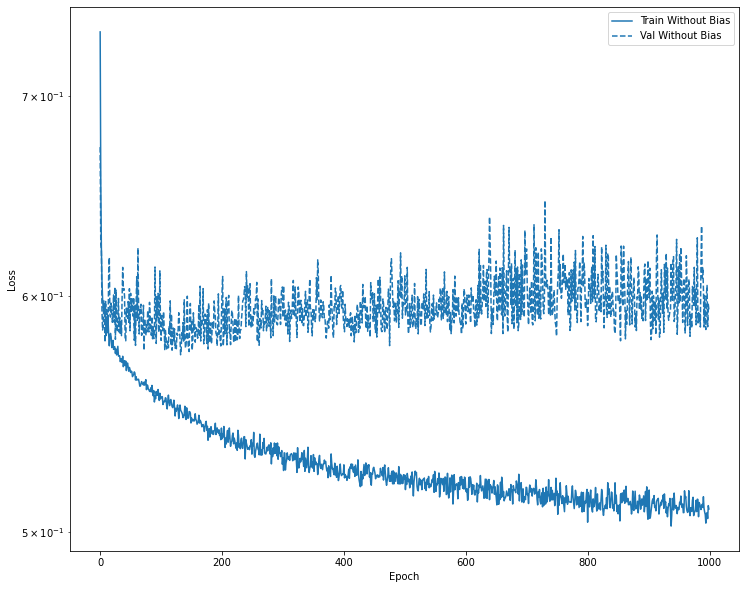

In [0]:
plot_loss(hist, "Without Bias", 0)

## Bias initialisation 

In [0]:
neg, pos = np.bincount(df_train['Target'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 15249
    Positive: 4082 (26.77% of total)



In [0]:
initial_bias = np.log([pos/neg])
initial_bias

array([-1.00637594])

In [0]:
import os
import tempfile
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

### With the first model

In [0]:
input_shape=(train_features.shape[1],1)
model = build_CNN(input_shape = input_shape, filters = [30,30], kernels = [4,4], output_bias= initial_bias, dropout = 0.2)
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_13 (Batc (None, 22, 1)             88        
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 19, 3)             15        
_________________________________________________________________
batch_normalization_14 (Batc (None, 19, 3)             76        
_________________________________________________________________
dropout_10 (Dropout)         (None, 19, 3)             0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 16, 30)            390       
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 8, 30)             0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 8, 30)            

In [0]:
metrics =["accuracy",keras.metrics.AUC(name='auc')] 
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=metrics)
hist_bias = model.fit(
    train_features,
    train_labels,
    batch_size=300,
    epochs=1000,
    #callbacks = [early_stopping],
    validation_data=(val_features, val_labels))
    # The class weights go here
    #class_weight=class_weight) 

In [0]:
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
  plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  
  plt.legend()

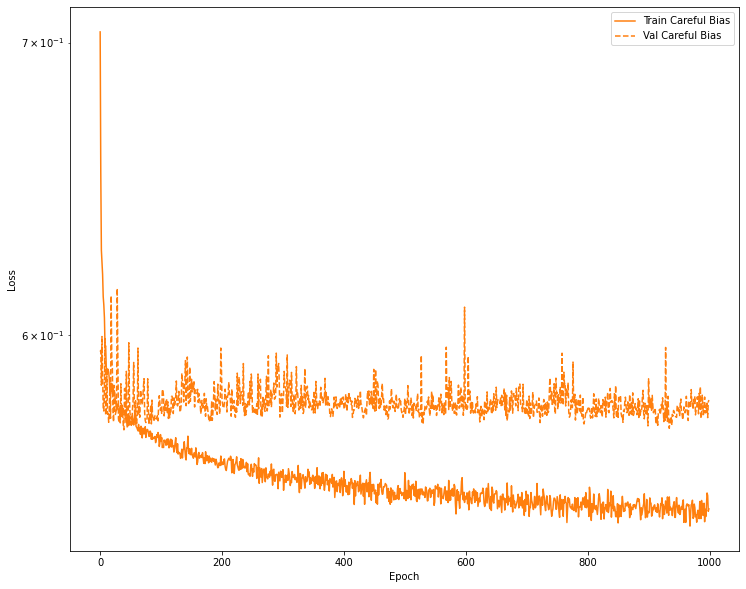

In [0]:
#plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(hist_bias, "Careful Bias", 1)

In [0]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.5769532801675015
accuracy :  0.7321311235427856
auc :  0.5790770649909973

True Negatives:  2212
False Positives:  27
False Negatives:  790
True Positives:  21
Total :  811


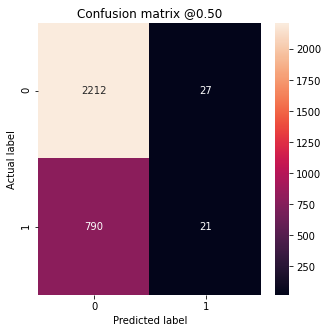

In [0]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=300, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)


### A second model

In [0]:
input_shape=(train_features.shape[1],1)
model2 = build_CNN(input_shape = input_shape, filters = [40,40, 15], kernels = [3,3, 2], output_bias= initial_bias, dropout= 0.1)
model2.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_30 (Batc (None, 22, 1)             88        
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 19, 3)             15        
_________________________________________________________________
batch_normalization_31 (Batc (None, 19, 3)             76        
_________________________________________________________________
dropout_23 (Dropout)         (None, 19, 3)             0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 17, 40)            400       
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 8, 40)             0         
_________________________________________________________________
batch_normalization_32 (Batc (None, 8, 40)            

In [0]:
metrics =["accuracy",keras.metrics.AUC(name='auc')] 
model2.compile(loss='binary_crossentropy', optimizer='Adam', metrics=metrics)
hist2 = model2.fit(
    train_features,
    train_labels,
    batch_size=300,
    epochs=1000,
    #callbacks = [early_stopping],
    validation_data=(val_features, val_labels))
    # The class weights go here
    #class_weight=class_weight) 

In [ ]:
#model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=metrics)
hist_2 = model2.fit(
    train_features,
    train_labels,
    batch_size=300,
    epochs=200,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels))
    # The class weights go here
    #class_weight=class_weight) 

### Baseline performance 

loss :  0.4093581143614332
accuracy :  0.8241623044013977
auc :  0.8768577575683594

True Negatives:  6874
False Positives:  256
False Negatives:  1460
True Positives:  1169
Total :  2629


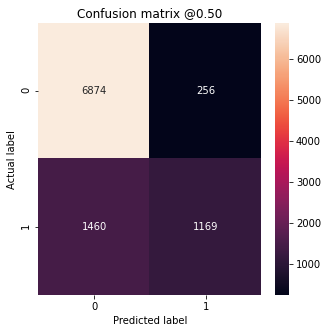

In [0]:
train_predictions_baseline_2 = model2.predict(train_features, batch_size=BATCH_SIZE)
baseline_results_2 = model2.evaluate(train_features, train_labels,
                                  batch_size=300, verbose=0)
for name, value in zip(model2.metrics_names, baseline_results_2):
  print(name, ': ', value)
print()

plot_cm(train_labels, train_predictions_baseline_2)


loss :  0.6038111379889192
accuracy :  0.7134426236152649
auc :  0.5951760411262512

True Negatives:  2046
False Positives:  193
False Negatives:  681
True Positives:  130
Total :  811


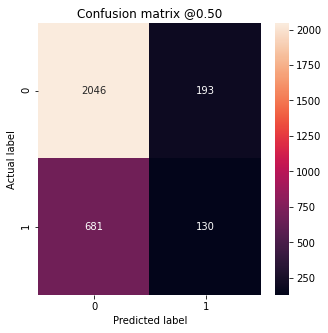

In [0]:
test_predictions_baseline_2 = model2.predict(test_features, batch_size=BATCH_SIZE)
baseline_results_2 = model2.evaluate(test_features, test_labels,
                                  batch_size=300, verbose=0)
for name, value in zip(model2.metrics_names, baseline_results_2):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline_2)


In [ ]:
plot_loss(hist_2, "With Bias and 0.5 dropout", 1)

In [0]:
plot_metrics(hist)

## Class weighting approach

In [0]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.68
Weight for class 1: 1.87


In [0]:
weighted_model = build_CNN(input_shape = input_shape, filters = [40,40, 15], kernels = [3,3, 2], output_bias= initial_bias, dropout= 0.1)
weighted_model.summary()


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_40 (Batc (None, 22, 1)             88        
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 19, 3)             15        
_________________________________________________________________
batch_normalization_41 (Batc (None, 19, 3)             76        
_________________________________________________________________
dropout_31 (Dropout)         (None, 19, 3)             0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 17, 40)            400       
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 8, 40)             0         
_________________________________________________________________
batch_normalization_42 (Batc (None, 8, 40)           

In [ ]:
#weighted_model.load_weights(initial_weights)

metrics =["accuracy", keras.metrics.AUC(name='auc')] 
weighted_model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=metrics)
weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=300,
    epochs=1000,
    #callbacks = [early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight) 


In [ ]:
weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=200,
    epochs=1000,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight) 

In [ ]:
plot_loss(weighted_history, "Weighted Bias", 1)

In [ ]:
plot_metrics(weighted_history)

### weighted model performance

loss :  0.6942554770923052
accuracy :  0.5783606767654419
auc :  0.5878475308418274

True Negatives:  1348
False Positives:  891
False Negatives:  395
True Positives:  416
Total :  811


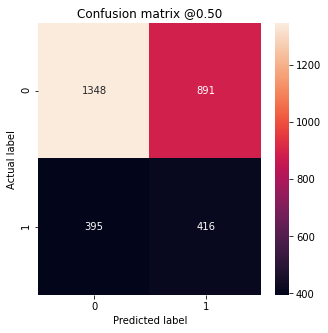

In [0]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

weighted_results_2 = weighted_model.evaluate(test_features, test_labels,
                                  batch_size=300, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results_2):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)


## Oversampling

In [0]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

In [0]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(7130, 22, 1)

In [0]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(14260, 22, 1)

In [0]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

11.0

In [0]:
resampled_model = build_CNN(input_shape = input_shape, filters = [40,40, 15], kernels = [3,3, 2], output_bias= 0, dropout= 0.1)
resampled_model.summary()


# Reset the bias to zero, since this dataset is balanced.
#output_layer = resampled_model.layers[-1] 
#output_layer.bias.assign([0])



Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_115 (Bat (None, 22, 1)             88        
_________________________________________________________________
conv1d_93 (Conv1D)           (None, 19, 3)             15        
_________________________________________________________________
batch_normalization_116 (Bat (None, 19, 3)             76        
_________________________________________________________________
dropout_91 (Dropout)         (None, 19, 3)             0         
_________________________________________________________________
conv1d_94 (Conv1D)           (None, 17, 40)            400       
_________________________________________________________________
max_pooling1d_69 (MaxPooling (None, 8, 40)             0         
_________________________________________________________________
batch_normalization_117 (Bat (None, 8, 40)           

In [0]:
metrics =["accuracy", keras.metrics.AUC(name='auc')] 
resampled_model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=metrics)

resampled_history = resampled_model.fit(
    resampled_features,
    resampled_labels,
    epochs=100,
    steps_per_epoch= int(resampled_steps_per_epoch),
    #callbacks = [early_stopping],
    validation_steps = 100,
    validation_data=(val_features, val_labels))
    # The class weights go here
    

Train on 14260 samples, validate on 2440 samples
Epoch 1/2
11/11 [==============================] - 3s 252ms/step - loss: 0.5358 - accuracy: 0.7278 - auc: 0.8051 - val_loss: 0.0069 - val_accuracy: 61.5574 - val_auc: 59.7592
Epoch 2/2
11/11 [==============================] - 1s 120ms/step - loss: 0.5368 - accuracy: 0.7270 - auc: 0.8040 - val_loss: 0.0069 - val_accuracy: 60.9016 - val_auc: 59.5331


In [0]:
metrics =["accuracy", keras.metrics.AUC(name='auc')] 

resampled_model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=metrics)
resampled_history = resampled_model.fit(
    resampled_features,
    resampled_labels,
    epochs=5,
    steps_per_epoch= int(resampled_steps_per_epoch),
    callbacks = [early_stopping],
    validation_steps = 100,
    validation_data=(val_features, val_labels))
    # The class weights go here
    

Train on 14260 samples, validate on 2440 samples
Epoch 1/5
11/11 [==============================] - 3s 251ms/step - loss: 0.5311 - accuracy: 0.7310 - auc: 0.8091 - val_loss: 0.0069 - val_accuracy: 62.0902 - val_auc: 59.6759
Epoch 2/5
11/11 [==============================] - 1s 125ms/step - loss: 0.5357 - accuracy: 0.7282 - auc: 0.8050 - val_loss: 0.0069 - val_accuracy: 60.6148 - val_auc: 59.4492
Epoch 3/5
11/11 [==============================] - 1s 119ms/step - loss: 0.5362 - accuracy: 0.7270 - auc: 0.8047 - val_loss: 0.0069 - val_accuracy: 61.7623 - val_auc: 59.6754
Epoch 4/5
11/11 [==============================] - 1s 122ms/step - loss: 0.5363 - accuracy: 0.7262 - auc: 0.8046 - val_loss: 0.0069 - val_accuracy: 61.5984 - val_auc: 59.6693
Epoch 5/5
11/11 [==============================] - 1s 120ms/step - loss: 0.5376 - accuracy: 0.7256 - auc: 0.8032 - val_loss: 0.0069 - val_accuracy: 61.4754 - val_auc: 59.4443


### Performance with oversampling

In [0]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=300)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=300)

loss :  0.44472549956027374
accuracy :  0.8094066977500916
auc :  0.8984197974205017

True Negatives:  5704
False Positives:  1426
False Negatives:  434
True Positives:  2195
Total :  2629


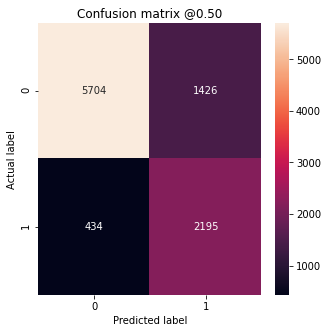

In [0]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=300)
train_results = resampled_model.evaluate(train_features, train_labels,
                                  batch_size=300, verbose=0)
for name, value in zip(resampled_model.metrics_names, train_results):
  print(name, ': ', value)
print()

plot_cm(train_labels, train_predictions_resampled)


loss :  0.6839074160231918
accuracy :  0.6131147742271423
auc :  0.6005640625953674

True Negatives:  1479
False Positives:  760
False Negatives:  420
True Positives:  391
Total :  811


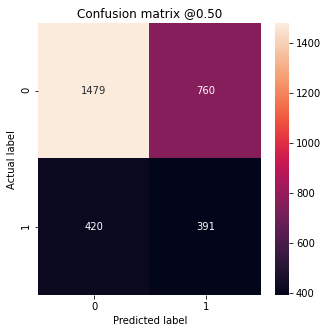

In [0]:
test_predictions_resampled = resampled_model.predict(test_features, batch_size=300)
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=300, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

loss :  0.6844620186774457
accuracy :  0.6127868890762329
auc :  0.5999758243560791

True Negatives:  1495
False Positives:  744
False Negatives:  437
True Positives:  374
Total :  811


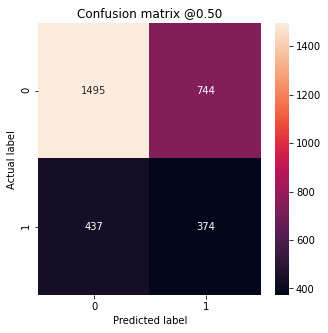

In [383]:
test_predictions_resampled = resampled_model.predict(test_features, batch_size=300)
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=300, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

In [ ]:
resampled_model = keras.models.load_model('resampled_model.h5', custom_objects=dependencies)

In [0]:
metrics =["accuracy", keras.metrics.AUC(name='auc')] 
resampled_model.save('resampled_model.h5')

In [0]:
model_copy= keras.models.clone_model(resampled_model)
model_copy.build((input_shape[0], 1)) # replace 10 with number of variables in input layer
model_copy.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=metrics)
model_copy.set_weights(resampled_model.get_weights())

In [0]:
#model_copy.compile(optimizer='Adam', loss='binary_crossentropy', metrics=metrics)

copy_history = model_copy.fit(
    resampled_features,
    resampled_labels,
    epochs=10,
    steps_per_epoch= int(resampled_steps_per_epoch),
    #callbacks = [early_stopping],
    validation_steps = 100,
    validation_data=(val_features, val_labels))
    # The class weights go here
    

We can see clearly that by oversampling we are overfitting on the training set. To fix it, adding a **ridge regularization** could be a goog idea.

## Regularized model

In [0]:
from keras import regularizers
from keras import Model

In [0]:
resampled_model.layers[:-1]

In [0]:
reg_model = build_CNN(input_shape = input_shape, filters = [40,40, 40], kernels = [3,3, 2], output_bias= initial_bias, dropout= 0.1)

reg_model_1 = Sequential( reg_model.layers[:-1]+
           [Dense(units=1, activation='sigmoid',kernel_regularizer=regularizers.l2(0),
                                activity_regularizer=regularizers.l1(0.001)) ]
                                    )
reg_model_1.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_139 (Bat (None, 22, 1)             88        
_________________________________________________________________
conv1d_113 (Conv1D)          (None, 19, 3)             15        
_________________________________________________________________
batch_normalization_140 (Bat (None, 19, 3)             76        
_________________________________________________________________
dropout_110 (Dropout)        (None, 19, 3)             0         
_________________________________________________________________
conv1d_114 (Conv1D)          (None, 17, 40)            400       
_________________________________________________________________
max_pooling1d_84 (MaxPooling (None, 8, 40)             0         
_________________________________________________________________
batch_normalization_141 (Bat (None, 8, 40)           

In [0]:
metrics =["accuracy", keras.metrics.AUC(name='auc')] 
reg_model_1.compile(loss='binary_crossentropy', optimizer='Adam', metrics=metrics)

reg_history = reg_model_1.fit(
    resampled_features,
    resampled_labels,
    epochs=100,
    steps_per_epoch= int(resampled_steps_per_epoch),
    #callbacks = [early_stopping],
    validation_steps = 100,
    validation_data=(val_features, val_labels))
    # The class weights go here
    

In [0]:
metrics =["accuracy", keras.metrics.AUC(name='auc')] 
reg_model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=metrics)

reg_history = reg_model.fit(
    resampled_features,
    resampled_labels,
    epochs=100,
    steps_per_epoch= int(resampled_steps_per_epoch),
    callbacks = [early_stopping],
    validation_steps = 1,
    validation_data=(val_features, val_labels))
    # The class weights go here
    

loss :  0.472423944424161
accuracy :  0.7832769751548767
auc :  0.8863608241081238

True Negatives:  5395
False Positives:  1735
False Negatives:  380
True Positives:  2249
Total :  2629


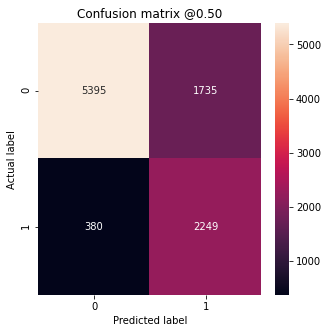

In [0]:
train_predictions_reg = reg_model.predict(train_features, batch_size=300)
train_results_reg = reg_model.evaluate(train_features, train_labels,
                                  batch_size=300, verbose=0)
for name, value in zip(reg_model.metrics_names, train_results_reg):
  print(name, ': ', value)
print()

plot_cm(train_labels, train_predictions_reg)


loss :  0.6787590276999552
accuracy :  0.5934426188468933
auc :  0.5881864428520203

True Negatives:  1418
False Positives:  821
False Negatives:  419
True Positives:  392
Total :  811


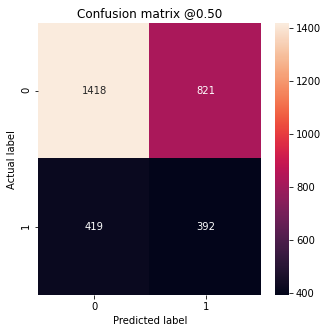

In [0]:
test_predictions_reg = reg_model.predict(test_features, batch_size=300)
reg_results = reg_model.evaluate(test_features, test_labels,
                                             batch_size=300, verbose=0)
for name, value in zip(reg_model.metrics_names, reg_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_reg)

loss :  0.6633986136952384
accuracy :  0.6072131395339966

True Negatives:  1674
False Positives:  565
False Negatives:  633
True Positives:  178
Total :  811


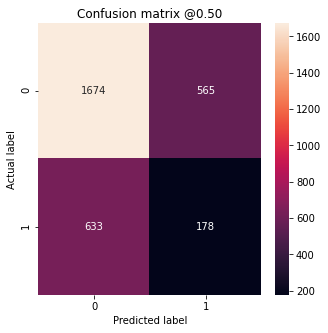

In [0]:
test_predictions_reg = reg_model.predict(test_features, batch_size=300)
reg_results = reg_model.evaluate(test_features, test_labels,
                                             batch_size=300, verbose=0)
for name, value in zip(reg_model.metrics_names, reg_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_reg)

### Add regularization to conv layers

In [0]:
reg_model = build_CNN(input_shape = input_shape, filters = [40,40, 15], kernels = [3,3, 2], output_bias= initial_bias, dropout= 0.2, reg = 0.1)
reg_model.summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_144 (Bat (None, 22, 1)             88        
_________________________________________________________________
conv1d_117 (Conv1D)          (None, 19, 3)             15        
_________________________________________________________________
batch_normalization_145 (Bat (None, 19, 3)             76        
_________________________________________________________________
dropout_114 (Dropout)        (None, 19, 3)             0         
_________________________________________________________________
conv1d_118 (Conv1D)          (None, 17, 40)            400       
_________________________________________________________________
max_pooling1d_87 (MaxPooling (None, 8, 40)             0         
_________________________________________________________________
batch_normalization_146 (Bat (None, 8, 40)           

In [0]:
metrics =["accuracy", keras.metrics.AUC(name='auc')] 
reg_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=metrics)

reg_history = reg_model.fit(
    resampled_features,
    resampled_labels,
    epochs=200,
    steps_per_epoch= int(resampled_steps_per_epoch),
    #callbacks = [early_stopping],
    validation_steps = 100,
    validation_data=(val_features, val_labels))
    # The class weights go here
    

In [0]:
metrics =["accuracy", keras.metrics.AUC(name='auc')] 
reg_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=metrics)

reg_history = reg_model.fit(
    resampled_features,
    resampled_labels,
    epochs=100,
    steps_per_epoch= int(resampled_steps_per_epoch),
    #callbacks = [early_stopping],
    validation_steps = 1,
    validation_data=(val_features, val_labels))
    # The class weights go here
    
    

loss :  0.4300402162205502
accuracy :  0.8448611497879028
auc :  0.9143071174621582

True Negatives:  6093
False Positives:  1037
False Negatives:  477
True Positives:  2152
Total :  2629


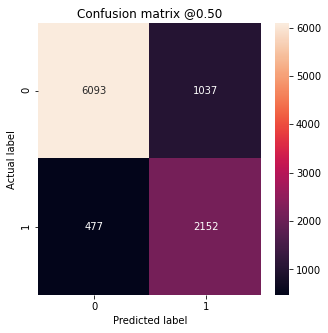

In [0]:
train_predictions_reg = reg_model.predict(train_features, batch_size=300)
train_results_reg = reg_model.evaluate(train_features, train_labels,
                                  batch_size=300, verbose=0)
for name, value in zip(reg_model.metrics_names, train_results_reg):
  print(name, ': ', value)
print()

plot_cm(train_labels, train_predictions_reg)


loss :  1.3337650377242292
accuracy :  0.7213114500045776
auc :  0.5293805003166199

True Negatives:  2156
False Positives:  83
False Negatives:  767
True Positives:  44
Total :  811


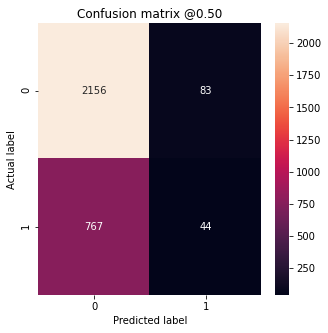

In [0]:
test_predictions_reg = reg_model.predict(test_features, batch_size=1000)
reg_results = reg_model.evaluate(test_features, test_labels,
                                             batch_size=1000, verbose=0)
for name, value in zip(reg_model.metrics_names, reg_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_reg)

### Train xgb with extracted features

In [0]:
resampled_model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_115 (Bat (None, 22, 1)             88        
_________________________________________________________________
conv1d_93 (Conv1D)           (None, 19, 3)             15        
_________________________________________________________________
batch_normalization_116 (Bat (None, 19, 3)             76        
_________________________________________________________________
dropout_91 (Dropout)         (None, 19, 3)             0         
_________________________________________________________________
conv1d_94 (Conv1D)           (None, 17, 40)            400       
_________________________________________________________________
max_pooling1d_69 (MaxPooling (None, 8, 40)             0         
_________________________________________________________________
batch_normalization_117 (Bat (None, 8, 40)           

In [0]:
feature_layer_model = keras.Model(
                     inputs=resampled_model.input,
                     outputs=resampled_model.get_layer("flatten_23").output)

In [0]:
feature_layer_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_115_inpu (None, 22, 1)             0         
_________________________________________________________________
batch_normalization_115 (Bat (None, 22, 1)             88        
_________________________________________________________________
conv1d_93 (Conv1D)           (None, 19, 3)             15        
_________________________________________________________________
batch_normalization_116 (Bat (None, 19, 3)             76        
_________________________________________________________________
dropout_91 (Dropout)         (None, 19, 3)             0         
_________________________________________________________________
conv1d_94 (Conv1D)           (None, 17, 40)            400       
_________________________________________________________________
max_pooling1d_69 (MaxPooling (None, 8, 40)             0   

In [0]:
def get_feature_layer(model, data, layer):
    
    
    
    total_layers = len(model.layers)
    
    fl_index = total_layers-1
    
    feature_layer_model = keras.Model(
                     inputs=model.input,
                     outputs=model.get_layer(layer).output)
    
    feature_layer_output = feature_layer_model.predict(data)
    
    return feature_layer_output

In [0]:
#layer = "flatten_23"
layer = "batch_normalization_119"

In [424]:
X_train = get_feature_layer(resampled_model, resampled_features, layer= layer).reshape(resampled_labels.shape[0],-1)
y_train = resampled_labels; X_train.shape

(14260, 15)

In [425]:
y_val = val_labels 
X_val = get_feature_layer(resampled_model, val_features, layer= layer).reshape(y_val.shape[0], -1)
X_val.shape

(2440, 15)

In [426]:
y_test = test_labels
X_test = get_feature_layer(resampled_model, test_features, layer= layer).reshape(y_test.shape[0], -1)
X_test.shape

(3050, 15)

In [427]:
import time
from xgboost import XGBClassifier
# create a default XGBoost classifier
model = XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           eval_metric=['error', 'auc'],
                                           gamma=0, learning_rate=0.1,
                                           max_delta_step=0, max_depth=3,
                                           min_child_weight=1, missing=None,
                                           n_estimators=100)
# define the eval set and metric
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["auc","error"]
# fit the model
model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1,
              eval_metric=['error', 'auc'], gamma=0, learning_rate=0.1,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
              n_estimators=100, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

In [428]:
from sklearn.metrics import accuracy_score, classification_report, auc
from sklearn.metrics import roc_auc_score
pred_test = model.predict(X_test)
pred_train = model.predict(X_train)

print('Train Accuracy: ', accuracy_score(y_train, pred_train))
print('Test Accuraccy: ', accuracy_score(y_test, pred_test))
print('Train auc: ', roc_auc_score(y_train, pred_train))
print('Test auc: ', roc_auc_score(y_test, pred_test))
print('Classification Report:')
print(classification_report(y_test,pred_test))


Train Accuracy:  0.8953015427769986
Test Accuraccy:  0.6524590163934426
Train auc:  0.8953015427769986
Test auc:  0.5702216453201264
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.75      0.76      2239
           1       0.36      0.39      0.38       811

    accuracy                           0.65      3050
   macro avg       0.57      0.57      0.57      3050
weighted avg       0.66      0.65      0.66      3050



True Negatives:  1710
False Positives:  529
False Negatives:  503
True Positives:  308
Total :  811


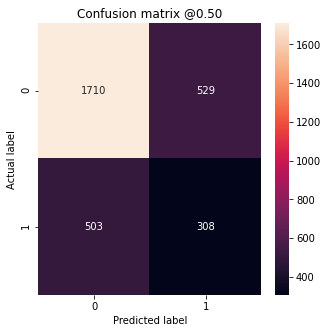

In [0]:
plot_cm(test_labels, pred_test)

In [0]:
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import StratifiedKFold , RandomizedSearchCV
# create a default XGBoost classifier
model = XGBClassifier(
    
    eval_metric=["error", "auc"]
)
# Create the grid search parameter grid and scoring funcitons
param_grid = {
    "learning_rate": [0.1, 0.01],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "subsample": [0.6, 0.8, 1.0],
    "max_depth": [2, 3, 4],
    "n_estimators": [100, 200, 300, 400],
    "reg_lambda": [1, 1.5, 2],
    "gamma": [0, 0.1, 0.3],
}
scoring = {
    'AUC': 'roc_auc', 
    'Accuracy': make_scorer(accuracy_score)
}

# create the Kfold object
num_folds = 10
kfold = StratifiedKFold(n_splits=num_folds)
# create the grid search object
n_iter=50
grid = RandomizedSearchCV(
    estimator=model, 
    param_distributions=param_grid,
    cv=kfold,
    scoring=scoring,
    
    n_iter=n_iter,
    refit="AUC",
)
# fit grid search


In [0]:
best_model = grid.fit(X_train,y_train, eval_set=[(X_train, y_train), (X_val, y_val)],verbose=False)

In [435]:
pred_test = best_model.predict(X_test)
pred_train = best_model.predict(X_train)

print('Train Accuracy: ', accuracy_score(y_train, pred_train))
print('Test Accuraccy: ', accuracy_score(y_test, pred_test))
print('Train auc: ', roc_auc_score(y_train, pred_train))
print('Test auc: ', roc_auc_score(y_test, pred_test))
print('Classification Report:')
print(classification_report(y_test,pred_test))


Train Accuracy:  0.9392005610098176
Test Accuraccy:  0.6645901639344263
Train auc:  0.9392005610098177
Test auc:  0.5674744152670763
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.77      0.77      2239
           1       0.37      0.36      0.36       811

    accuracy                           0.66      3050
   macro avg       0.57      0.57      0.57      3050
weighted avg       0.66      0.66      0.66      3050



In [0]:
pred_test = best_model.predict(X_test)

In [398]:
params

<bound method BaseEstimator.get_params of RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           eval_metric=['error', 'auc'],
                                           gamma=0, learning_rate=0.1,
                                           max_delta_step=0, max_depth=3,
                                           min_child_weight=1, missing=None,
                                           n_estimators=100, n_job...
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.3],
                                        'learning_rate': [0.1, 